# **Robinhood Dataset**

In order to improve user retention and lower churn, the growth team at Robinhood is interested in understanding why and which users withdraw money from their Robinhood account. A user is considered $churned$ when their equity value (amount of money in Robinhood account) falls below `$10` for a period of 28 consecutive calendar days or longer after having previously been at least `$10`.

There are 2 datasets provided for this project.

1. **features_data_csv**: contains a list of features for each user

   **List of columns**

   * risk_tolerance (3 categories)
   * investment_experience (4 categories)
   * liquidity_needs (3 categories)
   * platform (3 categories)
   * instrument_type_first_traded (11 categories)
   * time_horizon (3 categories)
   * user_id (unique for each user)
   * time_spent (float)
   * first_deposit_amount (float)

---
   
2. **equity_value_data.csv**: consists of entries for days when a user's account is at least $10

   **List of columns**

   * timestamp
   * close_equity (float - represents $ amount)
   * user_id (contains multiple entries for each user)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings('ignore')

In [2]:
features_data_df = pd.read_csv('features_data.csv')

In [3]:
features_data_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [4]:
equity_value_data_df = pd.read_csv('equity_value_data.csv')

In [5]:
equity_value_data_df.head()

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [6]:
features_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


In [7]:
equity_value_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     1119158 non-null  object 
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


In [8]:
# Convert timestamp to date/time format

equity_value_data_df['timestamp'] = pd.to_datetime(equity_value_data_df['timestamp'])

In [9]:
# Since each user_id has multiple entries, aggregate features for each user

equity_features_df = equity_value_data_df.groupby('user_id').agg(
    first_eq=('close_equity', 'first'),
    last_eq=('close_equity', 'last'),
    avg_eq=('close_equity', 'mean'),
    max_eq=('close_equity', 'max'),
    min_eq=('close_equity', 'min'),
    eq_volatility=('close_equity', 'std')).reset_index()
        

In [10]:
merge_df = features_data_df.merge(equity_features_df, on="user_id", how="left")

In [11]:
print(merge_df.head())
print(merge_df.info())

        risk_tolerance   investment_experience          liquidity_needs  \
0  high_risk_tolerance  limited_investment_exp  very_important_liq_need   
1   med_risk_tolerance  limited_investment_exp  very_important_liq_need   
2   med_risk_tolerance  limited_investment_exp  very_important_liq_need   
3   med_risk_tolerance  limited_investment_exp  very_important_liq_need   
4  high_risk_tolerance  limited_investment_exp  very_important_liq_need   

  platform  time_spent instrument_type_first_traded  first_deposit_amount  \
0  Android   33.129417                        stock                  40.0   
1  Android   16.573517                        stock                 200.0   
2      iOS   10.008367                        stock                  25.0   
3  Android    1.031633                        stock                 100.0   
4  Android    8.187250                        stock                  20.0   

         time_horizon                           user_id  first_eq  last_eq  \
0    med

In [12]:
merge_df['risk_tolerance'].value_counts()

risk_tolerance
high_risk_tolerance    3566
med_risk_tolerance     1779
low_risk_tolerance      239
Name: count, dtype: int64

In [13]:
merge_df['investment_experience'].value_counts()

investment_experience
limited_investment_exp      2578
no_investment_exp           1796
good_investment_exp         1134
extensive_investment_exp      76
Name: count, dtype: int64

In [14]:
merge_df['liquidity_needs'].value_counts()

liquidity_needs
very_important_liq_need        4217
somewhat_important_liq_need    1109
not_important_liq_need          258
Name: count, dtype: int64

In [15]:
merge_df['time_horizon'].value_counts()

time_horizon
short_time_horizon    2833
long_time_horizon     1833
med_time_horizon       918
Name: count, dtype: int64

In [16]:
merge_df['user_id'].value_counts()

user_id
895044c23edc821881e87da749c01034    1
7e08c9cad0eae740f604f7f68d87eab9    1
683946c73f78247ec28af650b6c94de0    1
e90167de1488fd0d97036ea082319070    1
9b090ef6fc85ca988a9bf540f98a73c2    1
                                   ..
3f678acb4c85f9a7ce1b80391249d29a    1
42f861f24a4c7f940c3131b30cc3e825    1
39f249ff12de668334b572d14479a2fd    1
71611ba08c759aa0e3e42bed016e7e45    1
49ee0531ee9dfbce0e7d9afa1c3d86f4    1
Name: count, Length: 5584, dtype: int64

In [17]:
# Label Encode Variables that may have ordinal meaning

encode = {}

for col in ['risk_tolerance', 'investment_experience', 'time_horizon']:
    enc = LabelEncoder()
    merge_df[col]= enc.fit_transform(merge_df[col])
    encode[col] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

for col, mapping in encode.items():
    print(f"Encode Labels for {col}: {mapping}")

Encode Labels for risk_tolerance: {'high_risk_tolerance': 0, 'low_risk_tolerance': 1, 'med_risk_tolerance': 2}
Encode Labels for investment_experience: {'extensive_investment_exp': 0, 'good_investment_exp': 1, 'limited_investment_exp': 2, 'no_investment_exp': 3}
Encode Labels for time_horizon: {'long_time_horizon': 0, 'med_time_horizon': 1, 'short_time_horizon': 2}


In [18]:
for col in ['risk_tolerance', 'investment_experience', 'time_horizon']:
    print(f"Unique values in {col}: {merge_df[col].unique()}")

Unique values in risk_tolerance: [0 2 1]
Unique values in investment_experience: [2 3 1 0]
Unique values in time_horizon: [1 2 0]


In [19]:
print("Risk Tolerance Mapping: {'low_risk_tolerance': 0, 'med_risk_tolerance': 1, 'high_risk_tolerance': 2}")
print("Investment Experience Mapping: {'no_investment_exp': 0, 'limited_investment_exp': 1, 'good_investment_exp': 2, 'extensive_investment_exp': 3}")
print("Time Horizon Mapping: {'short_time_horizon': 0, 'med_time_horizon': 1, 'long_time_horizon': 2}")

Risk Tolerance Mapping: {'low_risk_tolerance': 0, 'med_risk_tolerance': 1, 'high_risk_tolerance': 2}
Investment Experience Mapping: {'no_investment_exp': 0, 'limited_investment_exp': 1, 'good_investment_exp': 2, 'extensive_investment_exp': 3}
Time Horizon Mapping: {'short_time_horizon': 0, 'med_time_horizon': 1, 'long_time_horizon': 2}


In [20]:
print(merge_df[['risk_tolerance', 'investment_experience', 'time_horizon']].head(10))

   risk_tolerance  investment_experience  time_horizon
0               0                      2             1
1               2                      2             2
2               2                      2             0
3               2                      2             2
4               0                      2             0
5               2                      3             1
6               1                      1             0
7               0                      1             2
8               0                      1             2
9               2                      3             1


In [21]:
# Reverse mapping dictionaries
reverse_mapping = {
    'risk_tolerance': {0: 'low_risk_tolerance', 1: 'med_risk_tolerance', 2: 'high_risk_tolerance'},
    'investment_experience': {0: 'no_investment_exp', 1: 'limited_investment_exp', 
                              2: 'good_investment_exp', 3: 'extensive_investment_exp'},
    'time_horizon': {0: 'short_time_horizon', 1: 'med_time_horizon', 2: 'long_time_horizon'}
}

# Convert encoded values back to original categories for verification
merge_df['risk_tolerance_decoded'] = merge_df['risk_tolerance'].map(reverse_mapping['risk_tolerance'])
merge_df['investment_experience_decoded'] = merge_df['investment_experience'].map(reverse_mapping['investment_experience'])
merge_df['time_horizon_decoded'] = merge_df['time_horizon'].map(reverse_mapping['time_horizon'])

# Display some rows to compare original vs encoded
print(merge_df[['risk_tolerance', 'risk_tolerance_decoded',
                'investment_experience', 'investment_experience_decoded',
                'time_horizon', 'time_horizon_decoded']].head(10))


   risk_tolerance risk_tolerance_decoded  investment_experience  \
0               0     low_risk_tolerance                      2   
1               2    high_risk_tolerance                      2   
2               2    high_risk_tolerance                      2   
3               2    high_risk_tolerance                      2   
4               0     low_risk_tolerance                      2   
5               2    high_risk_tolerance                      3   
6               1     med_risk_tolerance                      1   
7               0     low_risk_tolerance                      1   
8               0     low_risk_tolerance                      1   
9               2    high_risk_tolerance                      3   

  investment_experience_decoded  time_horizon time_horizon_decoded  
0           good_investment_exp             1     med_time_horizon  
1           good_investment_exp             2    long_time_horizon  
2           good_investment_exp             0   short_t

In [22]:
for col in ['risk_tolerance', 'investment_experience', 'time_horizon']:
    print(f"Unique values in {col}: {merge_df[col].unique()}")

Unique values in risk_tolerance: [0 2 1]
Unique values in investment_experience: [2 3 1 0]
Unique values in time_horizon: [1 2 0]


In [23]:
# One Hot Encode Other Categorical Variables

merge_df = pd.get_dummies(merge_df, columns = ['platform', 'instrument_type_first_traded', 'liquidity_needs'], drop_first=True)

In [24]:
merge_df

,risk_tolerance,investment_experience,time_spent,first_deposit_amount,time_horizon,user_id,first_eq,last_eq,avg_eq,max_eq,...,instrument_type_first_traded_etp,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,liquidity_needs_somewhat_important_liq_need,liquidity_needs_very_important_liq_need
0,0,2,33.129417,40.0,1,895044c23edc821881e87da749c01034,38.62,81.22,77.118526,88.9000,...,False,False,False,False,False,True,False,False,False,True
1,2,2,16.573517,200.0,2,458b1d95441ced242949deefe8e4b638,322.34,382.52,351.411468,394.9200,...,False,False,False,False,False,True,False,False,False,True
2,2,2,10.008367,25.0,0,c7936f653d293479e034865db9bb932f,49.24,49.24,49.240000,49.2400,...,False,False,False,False,False,True,False,False,False,True
3,2,2,1.031633,100.0,2,b255d4bd6c9ba194d3a350b3e76c6393,102.62,190.87,186.040280,212.4600,...,False,False,False,False,False,True,False,False,False,True
4,0,2,8.187250,20.0,0,4a168225e89375b8de605cbc0977ae91,60.66,164.42,208.753365,483.7306,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,0,2,8.339283,300.0,0,03880c726d8a4e5db006afe4119ad974,2307.00,3022.58,2742.329510,3096.7200,...,False,False,False,False,False,True,False,False,False,True
5580,2,2,7.241383,100.0,2,ae8315109657f44852b24c6bca4decd6,204.52,504.84,310.029010,638.0800,...,False,False,False,False,False,True,False,False,True,False
5581,2,3,22.967167,50.0,2,f29c174989f9737058fe808fcf264135,40.75,451.61,116.134472,460.6100,...,False,False,False,False,False,True,False,False,False,True
5582,2,2,10.338417,100.0,0,24843497d1de88b2e7233f694436cb3a,95.71,321.88,330.172163,374.2500,...,False,False,False,False,False,True,False,False,True,False


In [25]:
# Scale Numerical Columns

# List of Numerical Columns to Scale

num_cols = ['time_spent', 'first_deposit_amount', 'first_eq', 'last_eq', 'avg_eq', 'max_eq', 'min_eq', 'eq_volatility']

# Initialize Scaler and apply transformation

scaler = StandardScaler()
merge_df[num_cols] = scaler.fit_transform(merge_df[num_cols])

# Check scaling

print(merge_df[num_cols].describe())

         time_spent  first_deposit_amount      first_eq       last_eq  \
count  5.584000e+03          5.584000e+03  5.584000e+03  5.584000e+03   
mean   2.544924e-18          3.053909e-17 -1.813258e-17 -2.544924e-18   
std    1.000090e+00          1.000090e+00  1.000090e+00  1.000090e+00   
min   -2.225475e-01         -2.991156e-01 -2.538930e-01 -2.830612e-01   
25%   -2.041754e-01         -2.755099e-01 -2.488167e-01 -2.776385e-01   
50%   -1.356513e-01         -2.519042e-01 -2.295577e-01 -2.501825e-01   
75%   -4.423107e-03         -6.305873e-02 -1.260242e-01 -1.127716e-01   
max    5.645198e+01          2.330657e+01  3.471561e+01  2.539776e+01   

             avg_eq        max_eq        min_eq  eq_volatility  
count  5.584000e+03  5.584000e+03  5.584000e+03   5.580000e+03  
mean  -3.244778e-17 -8.907233e-18 -7.157598e-18  -6.366870e-19  
std    1.000090e+00  1.000090e+00  1.000090e+00   1.000090e+00  
min   -3.049992e-01 -3.045094e-01 -2.300981e-01  -2.865381e-01  
25%   -2.956512e-

In [26]:
# Check for missing values

print(merge_df.isnull().sum())

risk_tolerance                                 0
investment_experience                          0
time_spent                                     0
first_deposit_amount                           0
time_horizon                                   0
user_id                                        0
first_eq                                       0
last_eq                                        0
avg_eq                                         0
max_eq                                         0
min_eq                                         0
eq_volatility                                  4
risk_tolerance_decoded                         0
investment_experience_decoded                  0
time_horizon_decoded                           0
platform_both                                  0
platform_iOS                                   0
instrument_type_first_traded_adr               0
instrument_type_first_traded_cef               0
instrument_type_first_traded_etp               0
instrument_type_firs

In [27]:
# eq_volatility could have missing values if there is only 1 equity record
# Fill missing values with 0

merge_df['eq_volatility'].fillna(0, inplace=True)

In [28]:
# Check for missing values again

print(merge_df.isnull().sum())

risk_tolerance                                 0
investment_experience                          0
time_spent                                     0
first_deposit_amount                           0
time_horizon                                   0
user_id                                        0
first_eq                                       0
last_eq                                        0
avg_eq                                         0
max_eq                                         0
min_eq                                         0
eq_volatility                                  0
risk_tolerance_decoded                         0
investment_experience_decoded                  0
time_horizon_decoded                           0
platform_both                                  0
platform_iOS                                   0
instrument_type_first_traded_adr               0
instrument_type_first_traded_cef               0
instrument_type_first_traded_etp               0
instrument_type_firs

In [29]:
print(equity_features_df.columns)

Index(['user_id', 'first_eq', 'last_eq', 'avg_eq', 'max_eq', 'min_eq',
       'eq_volatility'],
      dtype='object')


In [30]:
# Feature Engineering
# Calculate gaps bewteen equity records for users

# Ensure chronological order per user
equity_value_data_df = equity_value_data_df.sort_values(by=['user_id', 'timestamp'])

# Compute time difference between consecutive entries
equity_value_data_df['days_since_last'] = equity_value_data_df.groupby('user_id')['timestamp'].diff().dt.days

# Get the max gap per user
max_gaps = equity_value_data_df.groupby('user_id')['days_since_last'].max().reset_index()
max_gaps.rename(columns={'days_since_last': 'max_gap_days'}, inplace=True)

# Merge max_gap_days back into merge_df
merge_df = merge_df.merge(max_gaps, on='user_id', how='left')

# Fill missing values (users with no missing gaps get 0)
merge_df['max_gap_days'].fillna(0, inplace=True)

# Verify integration
print(merge_df[['user_id', 'max_gap_days']].head(10))


                            user_id  max_gap_days
0  895044c23edc821881e87da749c01034           4.0
1  458b1d95441ced242949deefe8e4b638           4.0
2  c7936f653d293479e034865db9bb932f           4.0
3  b255d4bd6c9ba194d3a350b3e76c6393           4.0
4  4a168225e89375b8de605cbc0977ae91           4.0
5  0322b1d744cc89ebbe6ebe70d824d922           8.0
6  f4cac8c1544b723ddedc9bdba81c64c0          34.0
7  bdc39d2fc664ef9a5e6713168057f892           4.0
8  85f2f0f54411b4f3e7a403ba902e7280           4.0
9  529ddd19dac72d55cde8e633340a9aed           4.0


In [31]:
# Check the distribution for 'max_gap_days'

print(merge_df['max_gap_days'].describe())

count    5584.000000
mean        8.179799
std        20.110849
min         0.000000
25%         4.000000
50%         4.000000
75%         4.000000
max       335.000000
Name: max_gap_days, dtype: float64


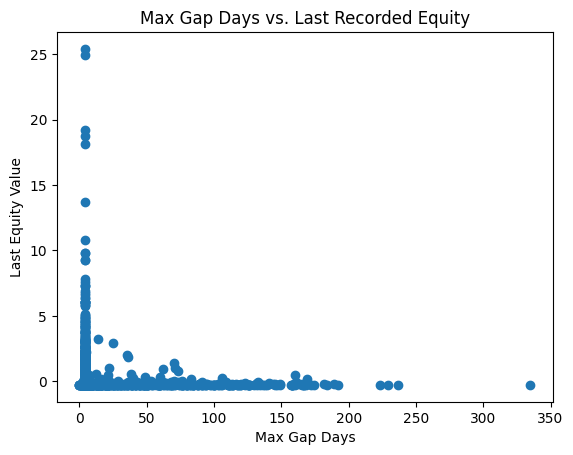

In [32]:
# Visualize relationship between 'max_gap_days' and 'last_eq'

plt.scatter(merge_df['max_gap_days'], merge_df['last_eq'])
plt.xlabel("Max Gap Days")
plt.ylabel("Last Equity Value")
plt.title("Max Gap Days vs. Last Recorded Equity")
plt.show()

In [33]:
# Create Binary Feature for Long Gaps (> 28 days)

merge_df['long_gap'] = (merge_df['max_gap_days'] > 28).astype(int)
print(merge_df[['max_gap_days', 'long_gap']].head(10))

   max_gap_days  long_gap
0           4.0         0
1           4.0         0
2           4.0         0
3           4.0         0
4           4.0         0
5           8.0         0
6          34.0         1
7           4.0         0
8           4.0         0
9           4.0         0


In [34]:
merge_df

,risk_tolerance,investment_experience,time_spent,first_deposit_amount,time_horizon,user_id,first_eq,last_eq,avg_eq,max_eq,...,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,liquidity_needs_somewhat_important_liq_need,liquidity_needs_very_important_liq_need,max_gap_days,long_gap
0,0,2,-0.008901,-0.280231,1,895044c23edc821881e87da749c01034,-0.250482,-0.278450,-0.299041,-0.300263,...,False,False,False,True,False,False,False,True,4.0,0
1,2,2,-0.115668,-0.204693,2,458b1d95441ced242949deefe8e4b638,-0.216663,-0.258943,-0.274691,-0.283792,...,False,False,False,True,False,False,False,True,4.0,0
2,2,2,-0.158005,-0.287313,0,c7936f653d293479e034865db9bb932f,-0.249216,-0.280521,-0.301516,-0.302397,...,False,False,False,True,False,False,False,True,4.0,0
3,2,2,-0.215895,-0.251904,2,b255d4bd6c9ba194d3a350b3e76c6393,-0.242853,-0.271351,-0.289371,-0.293612,...,False,False,False,True,False,False,False,True,4.0,0
4,0,2,-0.169749,-0.289673,0,4a168225e89375b8de605cbc0977ae91,-0.247854,-0.273063,-0.287355,-0.279012,...,False,False,False,True,False,False,False,True,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,0,2,-0.168769,-0.157481,0,03880c726d8a4e5db006afe4119ad974,0.019902,-0.088013,-0.062439,-0.138372,...,False,False,False,True,False,False,False,True,4.0,0
5580,2,2,-0.175849,-0.251904,2,ae8315109657f44852b24c6bca4decd6,-0.230707,-0.251023,-0.278364,-0.270704,...,False,False,False,True,False,False,True,False,39.0,1
5581,2,3,-0.074436,-0.275510,2,f29c174989f9737058fe808fcf264135,-0.250228,-0.254469,-0.295577,-0.280256,...,False,False,False,True,False,False,False,True,4.0,0
5582,2,2,-0.155877,-0.251904,0,24843497d1de88b2e7233f694436cb3a,-0.243677,-0.262869,-0.276576,-0.284904,...,False,False,False,True,False,False,True,False,4.0,0


In [35]:
# Define 'churned' based on 'max_gap_days'
merge_df['churned'] = (merge_df['max_gap_days'] >= 28).astype(int)

# Check churn distribution
print(merge_df['churned'].value_counts())

churned
0    5305
1     279
Name: count, dtype: int64


### **Question 1 - What percentage of users have churned in the data provided?**

In [37]:
churn_rate=279/5584*100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 5.00%


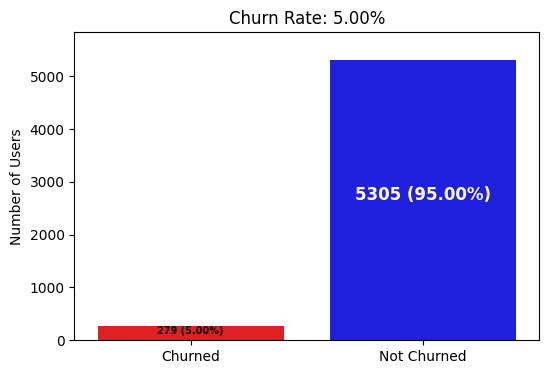

In [38]:
# Bar Chart Showing Percentage of Users Churned

users = merge_df.shape[0]
churned_users = merge_df['churned'].sum()
unchurned = users - churned_users
churn_percentage = (churned_users / users) * 100

plt.figure(figsize=(6,4))
sns.barplot(x=["Churned", "Not Churned"], y=[churned_users, unchurned], palette=["red", "blue"])
plt.text(0, churned_users * 0.4, f"{churned_users} ({churn_percentage:.2f}%)", ha='center', fontsize=7, color='black', weight='bold')
plt.text(1, unchurned / 2, f"{unchurned} ({100 - churn_percentage:.2f}%)", ha='center', fontsize=12, color='white', weight='bold')
plt.ylabel("Number of Users")
plt.title(f"Churn Rate: {churn_percentage:.2f}%")
plt.ylim(0, max(churned_users, unchurned) * 1.1)
plt.show()

In [39]:
merge_df.drop(columns=['long_gap'], inplace=True)

In [40]:
merge_df

,risk_tolerance,investment_experience,time_spent,first_deposit_amount,time_horizon,user_id,first_eq,last_eq,avg_eq,max_eq,...,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,liquidity_needs_somewhat_important_liq_need,liquidity_needs_very_important_liq_need,max_gap_days,churned
0,0,2,-0.008901,-0.280231,1,895044c23edc821881e87da749c01034,-0.250482,-0.278450,-0.299041,-0.300263,...,False,False,False,True,False,False,False,True,4.0,0
1,2,2,-0.115668,-0.204693,2,458b1d95441ced242949deefe8e4b638,-0.216663,-0.258943,-0.274691,-0.283792,...,False,False,False,True,False,False,False,True,4.0,0
2,2,2,-0.158005,-0.287313,0,c7936f653d293479e034865db9bb932f,-0.249216,-0.280521,-0.301516,-0.302397,...,False,False,False,True,False,False,False,True,4.0,0
3,2,2,-0.215895,-0.251904,2,b255d4bd6c9ba194d3a350b3e76c6393,-0.242853,-0.271351,-0.289371,-0.293612,...,False,False,False,True,False,False,False,True,4.0,0
4,0,2,-0.169749,-0.289673,0,4a168225e89375b8de605cbc0977ae91,-0.247854,-0.273063,-0.287355,-0.279012,...,False,False,False,True,False,False,False,True,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,0,2,-0.168769,-0.157481,0,03880c726d8a4e5db006afe4119ad974,0.019902,-0.088013,-0.062439,-0.138372,...,False,False,False,True,False,False,False,True,4.0,0
5580,2,2,-0.175849,-0.251904,2,ae8315109657f44852b24c6bca4decd6,-0.230707,-0.251023,-0.278364,-0.270704,...,False,False,False,True,False,False,True,False,39.0,1
5581,2,3,-0.074436,-0.275510,2,f29c174989f9737058fe808fcf264135,-0.250228,-0.254469,-0.295577,-0.280256,...,False,False,False,True,False,False,False,True,4.0,0
5582,2,2,-0.155877,-0.251904,0,24843497d1de88b2e7233f694436cb3a,-0.243677,-0.262869,-0.276576,-0.284904,...,False,False,False,True,False,False,True,False,4.0,0


In [41]:
# Compute Number of Gaps per User
merge_df['num_gaps'] = merge_df.groupby('user_id')['max_gap_days'].transform(lambda x: (x > 0).sum())

# Compute Average Length of Gaps per User
merge_df['avg_gap_length'] = merge_df.groupby('user_id')['max_gap_days'].transform(lambda x: x.mean())

# Fill NaN values with 0 (for users with no gaps)
merge_df['num_gaps'].fillna(0, inplace=True)
merge_df['avg_gap_length'].fillna(0, inplace=True)


In [42]:
# Drop user_id column

merge_df.drop(columns=['user_id'], inplace=True)

In [43]:
# Drop decoded columns

merge_df.drop(columns=['risk_tolerance_decoded', 'investment_experience_decoded', 'time_horizon_decoded'], inplace=True)

In [44]:
merge_df.to_csv('new_df.csv', index=False)

In [45]:
data_df = pd.read_csv('new_df.csv')

In [46]:
data_df.head()

,risk_tolerance,investment_experience,time_spent,first_deposit_amount,time_horizon,first_eq,last_eq,avg_eq,max_eq,min_eq,...,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,liquidity_needs_somewhat_important_liq_need,liquidity_needs_very_important_liq_need,max_gap_days,churned,num_gaps,avg_gap_length
0,0,2,-0.008901,-0.280231,1,-0.250482,-0.278450,-0.299041,-0.300263,-0.226011,...,False,True,False,False,False,True,4.0,0,1,4.0
1,2,2,-0.115668,-0.204693,2,-0.216663,-0.258943,-0.274691,-0.283792,-0.187751,...,False,True,False,False,False,True,4.0,0,1,4.0
2,2,2,-0.158005,-0.287313,0,-0.249216,-0.280521,-0.301516,-0.302397,-0.224494,...,False,True,False,False,False,True,4.0,0,1,4.0
3,2,2,-0.215895,-0.251904,2,-0.242853,-0.271351,-0.289371,-0.293612,-0.216870,...,False,True,False,False,False,True,4.0,0,1,4.0
4,0,2,-0.169749,-0.289673,0,-0.247854,-0.273063,-0.287355,-0.279012,-0.226809,...,False,True,False,False,False,True,4.0,0,1,4.0


In [47]:
print(data_df['num_gaps'].value_counts())
print(merge_df['avg_gap_length'].value_counts())

num_gaps
1    5580
0       4
Name: count, dtype: int64
avg_gap_length
4.0      4959
3.0       112
5.0        40
6.0        32
7.0        25
         ... 
105.0       1
98.0        1
147.0       1
78.0        1
93.0        1
Name: count, Length: 149, dtype: int64


In [48]:
# All users have either no gap or 1 gap when their equity value falls below $10
# Therefore avg_gap_length will be equivalent to map_gap_days and directly determine churn leading to 100% accuracy.

### **Question 2 - Build a Classifier**

In [49]:
# Split data into X features and y target

X = data_df.drop(columns=['churned', 'max_gap_days', 'avg_gap_length', 'num_gaps'])
y = data_df['churned']

In [50]:
# Splitting dataset into training, validation and test sets
# Training Set (60%), Validation Set (20%), Test Set (20%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [51]:
# Check if all data is numeric
print(X_train.dtypes.value_counts())  # Should only show numerical types (int64, float64)

bool       14
float64     8
int64       3
Name: count, dtype: int64


In [52]:
# Apply SMOTE due to imbalanced data

smote_data = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = smote_data.fit_resample(X_train, y_train)

In [53]:
# Build a Random Forest Classifer

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [54]:
# Make predictions on the training set

y_train_pred = rf.predict(X_train_smote)
y_train_proba = rf.predict_proba(X_train_smote)[:, 1] # Get churn probabilities

# Training set accuracy and AUC
train_acc = accuracy_score(y_train_smote, y_train_pred)
train_roc_auc = roc_auc_score(y_train_smote, y_train_proba)

# Training set confusion matrix
train_conf_mat = confusion_matrix(y_train_smote, y_train_pred)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Training AUC-ROC Score: {train_roc_auc:.2f}")
print(f"Training Confusion Matrix:\n{train_conf_mat}")
print(classification_report(y_train_smote, y_train_pred))



Training Accuracy: 1.00
Training AUC-ROC Score: 1.00
Training Confusion Matrix:
[[3183    0]
 [   0  954]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3183
           1       1.00      1.00      1.00       954

    accuracy                           1.00      4137
   macro avg       1.00      1.00      1.00      4137
weighted avg       1.00      1.00      1.00      4137



In [55]:
# Evaluate on Validation Set

# Predict on validation set

y_val_pred = rf.predict(X_valid)
y_val_proba = rf.predict_proba(X_valid)[:, 1]

# Validation set accuracy & AUC
val_acc = accuracy_score(y_valid, y_val_pred)
val_auc_roc = roc_auc_score(y_valid, y_val_proba)

# Validation confusion matrix
val_conf_mat = confusion_matrix(y_valid, y_val_pred)

print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation AUC-ROC Score: {val_auc_roc:.2f}")
print(f"Validation Confusion Matrix:\n{val_conf_mat}")
print(classification_report(y_valid, y_val_pred))

Validation Accuracy: 0.93
Validation AUC-ROC Score: 0.78
Validation Confusion Matrix:
[[1036   25]
 [  52    4]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1061
           1       0.14      0.07      0.09        56

    accuracy                           0.93      1117
   macro avg       0.55      0.52      0.53      1117
weighted avg       0.91      0.93      0.92      1117



In [56]:
# It appears that there is overfitting

In [57]:
# Apply Grid Search to find better parameters

# Define hyperparameter grid

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearch

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train_smote, y_train_smote)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [58]:
# Train the optimized model

rf_optimized = RandomForestClassifier(
    max_depth=15,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf_optimized.fit(X_train_smote, y_train_smote)  # Train on the training set


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [59]:
# Predictions on the validation set
y_valid_pred_opt = rf_optimized.predict(X_valid)
y_valid_prob_opt = rf_optimized.predict_proba(X_valid)[:, 1]  # Get churn probabilities

# Compute accuracy and ROC-AUC score
valid_accuracy_opt = accuracy_score(y_valid, y_valid_pred_opt)
valid_roc_auc_opt = roc_auc_score(y_valid, y_valid_prob_opt)

# Confusion matrix
valid_conf_mat_opt = confusion_matrix(y_valid, y_valid_pred_opt)

print("Optimized Validation Results:")
print(f"Optimized Validation Accuracy: {valid_accuracy_opt:.2f}")
print(f"Optimized Validation ROC-AUC Score: {valid_roc_auc_opt:.2f}")
print(f"Optimized Validation Confusion Matrix:\n{valid_conf_mat_opt}")
print(classification_report(y_valid, y_valid_pred_opt))

Optimized Validation Results:
Optimized Validation Accuracy: 0.90
Optimized Validation ROC-AUC Score: 0.77
Optimized Validation Confusion Matrix:
[[999  62]
 [ 48   8]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1061
           1       0.11      0.14      0.13        56

    accuracy                           0.90      1117
   macro avg       0.53      0.54      0.54      1117
weighted avg       0.91      0.90      0.91      1117



In [60]:
# Since the minority class is still not being detected, change the threshold for predictions

threshold = 0.4

y_valid_prob_opt_adj = rf_optimized.predict_proba(X_valid)[:, 1]

y_valid_pred_opt_adj = np.where(y_valid_prob_opt_adj > threshold, 1, 0)

# Re-check classification scores

print("New Threshold Model Performance")
print(classification_report(y_valid, y_valid_pred_opt_adj))
print(f"Adjusted Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_opt_adj):.2f}")
print(f"Adjusted Validation ROC-AUC Score: {roc_auc_score(y_valid, y_valid_prob_opt_adj):.2f}")


New Threshold Model Performance
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1061
           1       0.12      0.27      0.16        56

    accuracy                           0.86      1117
   macro avg       0.54      0.58      0.54      1117
weighted avg       0.92      0.86      0.89      1117

Adjusted Validation Accuracy: 0.86
Adjusted Validation ROC-AUC Score: 0.77


In [61]:
# Apply the higher class weight for churned users

rf_adjusted = RandomForestClassifier(
    max_depth=15,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    class_weight={0: 1, 1: 1},
    random_state=42
)

rf_adjusted.fit(X_train_smote, y_train_smote)  # Train on the training set

RandomForestClassifier(class_weight={0: 1, 1: 1}, max_depth=15,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [62]:
# Predictions on the validation set with adjusted weight

y_valid_pred_adj = rf_adjusted.predict(X_valid)
y_valid_prob_adj = rf_adjusted.predict_proba(X_valid)[:, 1]  # Get churn probabilities

# Compute accuracy and ROC-AUC score
valid_accuracy_adj = accuracy_score(y_valid, y_valid_pred_adj)
valid_roc_auc_adj = roc_auc_score(y_valid, y_valid_prob_adj)

# Confusion matrix
valid_conf_mat_adj = confusion_matrix(y_valid, y_valid_pred_adj)

print("Optimized Validation Results:")
print(f"Optimized Validation Accuracy: {valid_accuracy_opt:.2f}")
print(f"Optimized Validation ROC-AUC Score: {valid_roc_auc_opt:.2f}")
print(f"Optimized Validation Confusion Matrix:\n{valid_conf_mat_opt}")
print(classification_report(y_valid, y_valid_pred_adj))

Optimized Validation Results:
Optimized Validation Accuracy: 0.90
Optimized Validation ROC-AUC Score: 0.77
Optimized Validation Confusion Matrix:
[[999  62]
 [ 48   8]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1061
           1       0.10      0.05      0.07        56

    accuracy                           0.93      1117
   macro avg       0.53      0.51      0.52      1117
weighted avg       0.91      0.93      0.92      1117



In [63]:
# Apply ADASYN instead of SMOTE
# ADASYN helps when the minority class is difficult to learn by generating harder to classify cases

adasyn = ADASYN(sampling_strategy=0.3, random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Train Random Forest on ADASYN-balanced data
rf_adasyn = RandomForestClassifier(
    max_depth=15,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf_adasyn.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [64]:
# Predictions on the validation set with adjusted weight

y_valid_prob_ada = rf_adasyn.predict_proba(X_valid)[:, 1]
y_valid_pred_ada = np.where(y_valid_prob_ada > 0.4, 1, 0)

# Compute accuracy and ROC-AUC score
valid_accuracy_ada = accuracy_score(y_valid, y_valid_pred_ada)
valid_roc_auc_ada = roc_auc_score(y_valid, y_valid_prob_ada)

# Confusion matrix
valid_conf_mat_ada = confusion_matrix(y_valid, y_valid_pred_ada)

print("Model Performance (ADASYN + Threshold = 0.4):")
print(classification_report(y_valid, y_valid_pred_ada))
print(f"Final Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_ada):.2f}")
print(f"Final Validation ROC-AUC Score: {roc_auc_score(y_valid, y_valid_prob_ada):.2f}")

Model Performance (ADASYN + Threshold = 0.4):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1061
           1       0.14      0.32      0.20        56

    accuracy                           0.87      1117
   macro avg       0.55      0.61      0.56      1117
weighted avg       0.92      0.87      0.89      1117

Final Validation Accuracy: 0.87
Final Validation ROC-AUC Score: 0.79


In [65]:
# Predict on the Test Set

y_test_prob_ada = rf_adasyn.predict_proba(X_test)[:, 1]
y_test_pred_ada = np.where(y_valid_prob_ada > 0.4, 1, 0)

# Compute accuracy and ROC-AUC score
test_accuracy_ada = accuracy_score(y_test, y_test_pred_ada)
test_roc_auc_ada = roc_auc_score(y_test, y_test_prob_ada)

# Confusion matrix
test_conf_mat_ada = confusion_matrix(y_test, y_test_pred_ada)

print("Model Performance (ADASYN + Threshold = 0.4):")
print(classification_report(y_test, y_test_pred_ada))
print(f"Final Validation Accuracy: {accuracy_score(y_test, y_test_pred_ada):.2f}")
print(f"Final Validation ROC-AUC Score: {roc_auc_score(y_test, y_test_prob_ada):.2f}")

Model Performance (ADASYN + Threshold = 0.4):
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1061
           1       0.05      0.11      0.07        56

    accuracy                           0.85      1117
   macro avg       0.50      0.50      0.49      1117
weighted avg       0.90      0.85      0.87      1117

Final Validation Accuracy: 0.85
Final Validation ROC-AUC Score: 0.79


In [66]:
# Final Model: Random Forest (ADASYN+Class Weighting {0:1, 1:2})
# Recall improved without hurting precision

rf_final_adjusted = RandomForestClassifier(
    max_depth=15,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    class_weight={0:1, 1:2},  # Give churned users more weight
    random_state=42
)

rf_final_adjusted.fit(X_train_adasyn, y_train_adasyn)

# Predict on test set
y_test_prob_final = rf_final_adjusted.predict_proba(X_test)[:, 1]
y_test_pred_final = np.where(y_test_prob_final > 0.4, 1, 0)

print("Final Adjusted Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred_final))
print(f"Final Test Accuracy: {accuracy_score(y_test, y_test_pred_final):.2f}")
print(f"Final Test ROC-AUC Score: {roc_auc_score(y_test, y_test_prob_final):.2f}")

Final Adjusted Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1061
           1       0.20      0.38      0.26        56

    accuracy                           0.89      1117
   macro avg       0.58      0.65      0.60      1117
weighted avg       0.93      0.89      0.91      1117

Final Test Accuracy: 0.89
Final Test ROC-AUC Score: 0.81


### **Question 3 - List the Most Important Features**

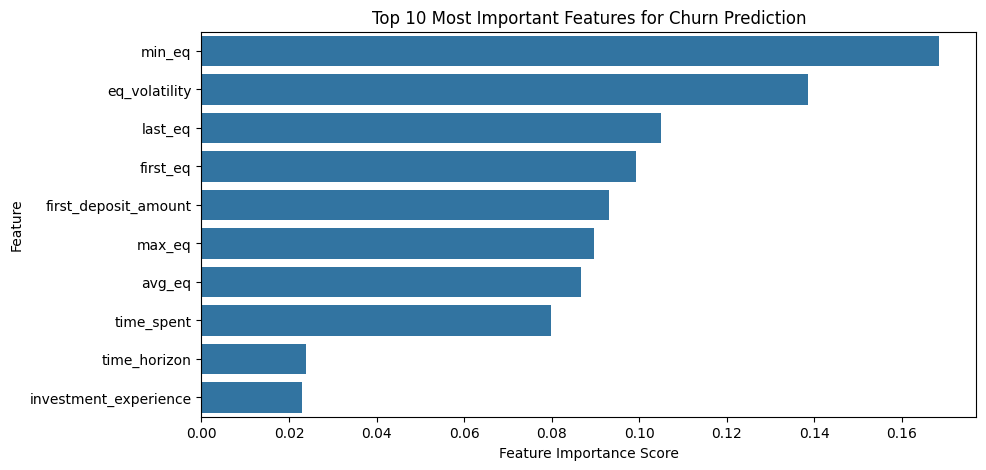

In [67]:
# Feature Importance

feature_imp = rf_final_adjusted.feature_importances_
features = X_train_adasyn.columns

# Create a dataframe

imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_imp})
imp_df = imp_df.sort_values(by = "Importance", ascending =False)

# Plot top 10 most important features

plt.figure(figsize=(10,5))
sns.barplot(x=imp_df["Importance"][:10], y=imp_df["Feature"][:10])
plt.title("Top 10 Most Important Features for Churn Prediction")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()

In [68]:
# Display feature importance for Top 5 Features

print(imp_df.head())

                 Feature  Importance
9                 min_eq    0.168589
10         eq_volatility    0.138563
6                last_eq    0.105002
5               first_eq    0.099337
3   first_deposit_amount    0.093072


In [69]:
# Check correlation of eq-related features with churn
eq_features = ['min_eq', 'max_eq', 'eq_volatility', 'avg_eq', 'last_eq', 'first_eq']
print(data_df[eq_features + ['churned']].corr()['churned'].sort_values(ascending=False))

churned          1.000000
eq_volatility   -0.019979
max_eq          -0.033296
first_eq        -0.040975
last_eq         -0.043645
avg_eq          -0.043839
min_eq          -0.048227
Name: churned, dtype: float64


In [70]:
# Confirms that equity features are not directly determing churn

In [71]:
# Try XGBoost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=2,  # Adjusted for class imbalance
    random_state=42
)

xgb_model.fit(X_train_adasyn, y_train_adasyn)

# Predict on test set
y_test_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred_xgb = np.where(y_test_prob_xgb > 0.4, 1, 0)

print("XGBoost Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred_xgb))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.2f}")
print(f"Test ROC-AUC Score: {roc_auc_score(y_test, y_test_prob_xgb):.2f}")


XGBoost Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1061
           1       0.18      0.27      0.22        56

    accuracy                           0.90      1117
   macro avg       0.57      0.60      0.58      1117
weighted avg       0.92      0.90      0.91      1117

Test Accuracy: 0.90
Test ROC-AUC Score: 0.76


In [246]:
# Try Logistic Regression

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_adasyn, y_train_adasyn)

# Predict on test set
y_test_prob_log = log_reg.predict_proba(X_test)[:, 1]
y_test_pred_log = np.where(y_test_prob_log > 0.4, 1, 0)

print("Logistic Regression Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred_log))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_log):.2f}")
print(f"Test ROC-AUC Score: {roc_auc_score(y_test, y_test_prob_log):.2f}")


Logistic Regression Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.41      0.57      1061
           1       0.06      0.73      0.11        56

    accuracy                           0.42      1117
   macro avg       0.51      0.57      0.34      1117
weighted avg       0.92      0.42      0.55      1117

Test Accuracy: 0.42
Test ROC-AUC Score: 0.64


In [ ]:
# ADASYN had the best precision/recall tradeoff